In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-probability/water_potability.csv


# KNN 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# Charger les données
data = pd.read_csv('/kaggle/input/water-probability/water_potability.csv')

# Afficher les premières lignes pour comprendre la structure
print(data.head())

# Vérifier les valeurs manquantes
print(data.isnull().sum())

# Séparer les features (X) et la target (y)
X = data.drop('Potability', axis=1)  # Features
y = data['Potability']  # Target

# Imputer les valeurs manquantes avec la médiane
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Définir la fonction KNN
def knn_classifier(X, y, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    return knn


         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [4]:
# Appliquer la validation croisée
knn = knn_classifier(X_scaled, y, n_neighbors=5)
cv_scores = cross_val_score(knn, X_scaled, y, cv=5)  # 5-fold cross-validation
print(f"KNN Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

KNN Cross-Validation Scores: [0.5945122  0.58473282 0.61068702 0.57099237 0.61374046]
Mean CV Accuracy: 0.5949329733755354


**Interprétation :**

Les scores de validation croisée montrent la performance du modèle sur 5 folds (sous-ensembles) différents des données.

La précision moyenne de 59.49 % indique que le modèle a une performance modérée, mais pas excellente.

Les scores varient entre 57.10 % et 61.37 %, ce qui suggère que le modèle est relativement stable, mais il y a une certaine variabilité dans sa performance selon les sous-ensembles de données.

In [5]:
# Optimiser le nombre de voisins avec GridSearchCV
param_grid = {'n_neighbors': range(1, 30)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

print("Meilleur nombre de voisins :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

Meilleur nombre de voisins : {'n_neighbors': 28}
Meilleure accuracy : 0.6337032210016756


**Interprétation :**

Le meilleur nombre de voisins trouvé par GridSearchCV est 28, ce qui signifie que le modèle fonctionne mieux lorsqu'il considère les 28 points les plus proches pour prendre une décision.

La meilleure précision obtenue après optimisation est de 63.37 %, ce qui est une amélioration par rapport à la précision moyenne de la validation croisée initiale (59.49 %).

Cela montre que l'optimisation des hyperparamètres a permis d'améliorer la performance du modèle.

In [6]:
# Utiliser le meilleur modèle pour prédire 
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_scaled)
print("KNN Accuracy (sur l'ensemble complet) :", accuracy_score(y, y_pred))
print("Classification Report (sur l'ensemble complet) :\n", classification_report(y, y_pred))

KNN Accuracy (sur l'ensemble complet) : 0.6730769230769231
Classification Report (sur l'ensemble complet) :
               precision    recall  f1-score   support

           0       0.66      0.96      0.78      1998
           1       0.77      0.23      0.35      1278

    accuracy                           0.67      3276
   macro avg       0.72      0.59      0.57      3276
weighted avg       0.70      0.67      0.61      3276



**Interprétation :**

+ Accuracy : Le modèle atteint une précision de 67.31 % sur l'ensemble complet des données. Cela signifie qu'il classe correctement environ 67 % des échantillons.

+ Precision, Recall, F1-Score :

---> Pour la classe 0 (eau non potable) :

Precision : 0.66 (66 % des échantillons prédits comme non potables sont corrects).

Recall : 0.96 (96 % des échantillons réellement non potables sont correctement identifiés).

F1-Score : 0.78 (bon équilibre entre précision et rappel pour la classe 0).

--->Pour la classe 1 (eau potable) :

Precision : 0.77 (77 % des échantillons prédits comme potables sont corrects).

Recall : 0.23 (seulement 23 % des échantillons réellement potables sont correctement identifiés).

F1-Score : 0.35 (faible performance pour la classe 1).

+ Déséquilibre des classes :

Le modèle est biaisé vers la classe 0 (non potable), comme en témoigne le rappel élevé (0.96) pour cette classe et le rappel très faible (0.23) pour la classe 1 (potable).

Cela suggère que le modèle a du mal à identifier correctement les échantillons d'eau potable, ce qui peut être dû à un déséquilibre dans les données ou à une complexité inhérente à la distinction entre les deux classes.

**Analyse globale**

--- Performance du modèle :

Le modèle KNN atteint une précision globale de 67.31 %, ce qui est acceptable mais pas optimal.

La performance est nettement meilleure pour la classe 0 (non potable) que pour la classe 1 (potable), ce qui indique un déséquilibre dans la capacité du modèle à prédire les deux classes.

--- Problèmes identifiés :

Déséquilibre de classes : Le modèle est biaisé vers la classe majoritaire (non potable), ce qui affecte sa capacité à prédire correctement la classe minoritaire (potable).

Complexité des données : Les caractéristiques des données peuvent ne pas être suffisamment discriminantes pour permettre au modèle de bien séparer les deux classes.

**Conclusion**
Le modèle KNN montre une performance modérée avec une précision globale de 67.31 %, mais il souffre d'un déséquilibre entre les classes, en particulier une faible capacité à identifier correctement les échantillons d'eau potable. Pour améliorer les résultats, il est recommandé de rééquilibrer les classes, d'essayer d'autres modèles et d'optimiser davantage les hyperparamètres.


L'utilisation d'un modèle SVM (Support Vector Machine) est une excellente idée pour voir s'il peut mieux gérer les déséquilibres de classes que KNN. Les SVM sont connus pour leur capacité à gérer des données complexes et à trouver des frontières de décision optimales, même dans des espaces de grande dimension. 

# SVM

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE  # Pour rééquilibrer les classes


# Rééquilibrer les classes avec SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Définir le modèle SVM
svm = SVC(kernel='rbf', random_state=42)

# Appliquer la validation croisée
cv_scores = cross_val_score(svm, X_resampled, y_resampled, cv=5, scoring='accuracy')  # 5-fold cross-validation
print(f"SVM Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")


SVM Cross-Validation Scores: [0.58875    0.63954944 0.61451815 0.63579474 0.66332916]
Mean CV Accuracy: 0.6283882978723404


**Interprétation**

---> Scores de validation croisée :

Les scores de validation croisée montrent la performance du modèle sur 5 folds (sous-ensembles) différents des données.

Les scores varient entre 58.88 % et 66.33 %, ce qui indique une certaine variabilité dans la performance du modèle selon les sous-ensembles de données.

La moyenne des scores de validation croisée est de 62.84 %, ce qui est une amélioration par rapport à la performance du modèle KNN (59.49 %).

---> Performance globale :

Une accuracy moyenne de 62.84 % suggère que le modèle SVM est légèrement meilleur que le modèle KNN pour ce problème.

Cependant, cette performance reste modérée et pourrait être améliorée.

Vérifier la distribution des classes

In [8]:
print(y.value_counts())

Potability
0    1998
1    1278
Name: count, dtype: int64


La distribution des classes montre un déséquilibre entre les deux classes :

Classe 0 (eau non potable) : 1998 échantillons

Classe 1 (eau potable) : 1278 échantillons

Cela signifie que la classe 0 est majoritaire, représentant environ 61 % des données, tandis que la classe 1 est minoritaire, représentant environ 39 % des données. Ce déséquilibre peut expliquer pourquoi les modèles (KNN et SVM) ont des difficultés à prédire correctement la classe minoritaire (eau potable).

**Solution:**

Pour améliorer la performance de mon modèle et mieux gérer le déséquilibre des classes, je vais explorer d'autres algorithmes de machine learning. En particulier, je vais essayer **Random Forest**, un modèle robuste qui gère bien les déséquilibres de classes grâce au paramètre `class_weight='balanced'`. Ce paramètre permet d'attribuer des poids inversement proportionnels à la fréquence des classes, pénalisant davantage les erreurs sur la classe minoritaire. Cela devrait aider à améliorer le rappel pour la classe "eau potable" tout en maintenant une bonne performance globale.

# Random Forest

Le modèle Random Forest est défini avec class_weight='balanced' pour gérer le déséquilibre des classes.

In [9]:
from sklearn.ensemble import RandomForestClassifier


# Définir le modèle Random Forest avec class_weight='balanced'
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Appliquer la validation croisée
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='accuracy')  # 5-fold cross-validation
print(f"Random Forest Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

# Entraîner le modèle sur l'ensemble complet (optionnel)
rf.fit(X_resampled, y_resampled)

# Prédire sur l'ensemble complet (optionnel)
y_pred = rf.predict(X_resampled)
print("Random Forest Accuracy (sur l'ensemble complet) :", accuracy_score(y_resampled, y_pred))
print("Classification Report (sur l'ensemble complet) :\n", classification_report(y_resampled, y_pred))

Random Forest Cross-Validation Scores: [0.63625    0.68085106 0.63204005 0.73341677 0.79849812]
Mean CV Accuracy: 0.6962112015018774
Random Forest Accuracy (sur l'ensemble complet) : 1.0
Classification Report (sur l'ensemble complet) :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1998
           1       1.00      1.00      1.00      1998

    accuracy                           1.00      3996
   macro avg       1.00      1.00      1.00      3996
weighted avg       1.00      1.00      1.00      3996



**Interpretation:**

---> Performance élevée :

Le modèle Random Forest montre une performance nettement meilleure que les modèles précédents (KNN et SVM), avec une accuracy moyenne de 69.62 % en validation croisée.

Sur l'ensemble complet, le modèle atteint une accuracy de 100 %, ce qui est excellent.

---> Gestion du déséquilibre des classes :

Le paramètre class_weight='balanced' a permis au modèle de bien gérer le déséquilibre des classes, comme en témoignent les scores parfaits pour les deux classes.

---> Robustesse :

Random Forest est un modèle robuste qui gère bien les données complexes et les déséquilibres de classes.

---> Sur-ajustement (Overfitting) :

Une accuracy de 100 % sur l'ensemble complet peut indiquer un sur-ajustement, c'est-à-dire que le modèle a appris par cœur les données d'entraînement et pourrait ne pas bien généraliser à de nouvelles données.

Cela est également suggéré par la variabilité des scores de validation croisée (de 63.63 % à 79.85 %).

---> Validation croisée :

La performance en validation croisée (69.62 %) est nettement inférieure à la performance sur l'ensemble complet (100 %), ce qui renforce l'hypothèse de sur-ajustement.

**Optimisation des hyperparamètres :**

On utilise GridSearchCV pour optimiser les hyperparamètres de Random Forest, comme n_estimators, max_depth, et min_samples_split.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)


Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Meilleure accuracy : 0.7019712140175219


La meilleure accuracy obtenue après optimisation est de 70.19 %, ce qui est une amélioration par rapport à la performance initiale (69.62 % en validation croisée).

Cela montre que l'optimisation des hyperparamètres a permis d'améliorer légèrement la performance du modèle.

# Decision Tree

Pour continuer à explorer les modèles de machine learning adaptés à mon problème de classification avec déséquilibre des classes, je vais maintenant appliquer un Arbre de Décision (**Decision Tree**, DT). Ce modèle est plus simple que Random Forest, mais il offre une interprétabilité directe et peut servir de base pour comprendre comment les décisions sont prises. Étant donné que Random Forest a montré une performance prometteuse avec une accuracy de **70.19** % après optimisation, je m'attends à ce que l'Arbre de Décision, bien que potentiellement moins performant, puisse fournir des insights sur les caractéristiques les plus importantes pour prédire la potabilité de l'eau. De plus, en utilisant le paramètre class_weight='balanced', je peux gérer le déséquilibre des classes de manière similaire à Random Forest.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Définir le modèle Decision Tree avec class_weight='balanced'
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Appliquer la validation croisée
cv_scores = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Decision Tree Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

# Entraîner le modèle sur l'ensemble complet (optionnel)
dt.fit(X_resampled, y_resampled)

# Prédire sur l'ensemble complet (optionnel)
y_pred = dt.predict(X_resampled)
print("Decision Tree Accuracy (sur l'ensemble complet) :", accuracy_score(y_resampled, y_pred))
print("Classification Report (sur l'ensemble complet) :\n", classification_report(y_resampled, y_pred))

Decision Tree Cross-Validation Scores: [0.5625     0.58072591 0.58322904 0.62953692 0.6795995 ]
Mean CV Accuracy: 0.6071182728410512
Decision Tree Accuracy (sur l'ensemble complet) : 1.0
Classification Report (sur l'ensemble complet) :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1998
           1       1.00      1.00      1.00      1998

    accuracy                           1.00      3996
   macro avg       1.00      1.00      1.00      3996
weighted avg       1.00      1.00      1.00      3996



**Interprétation des résultats:**

---> Scores de validation croisée
Les scores de validation croisée montrent la performance du modèle sur 5 folds (sous-ensembles) différents des données.

Les scores varient entre 56.25 % et 67.96 %, ce qui indique une variabilité modérée dans la performance du modèle selon les sous-ensembles de données.

La moyenne des scores de validation croisée est de 60.71 %, ce qui est inférieur à la performance de Random Forest (70.19 %).

---> Performance sur l'ensemble complet
Le modèle atteint une accuracy de 100 % sur l'ensemble complet des données.

Le rapport de classification montre une précision, un rappel et un F1-score parfaits (1.0) pour les deux classes.

**Visualiser l'arbre de décision:**

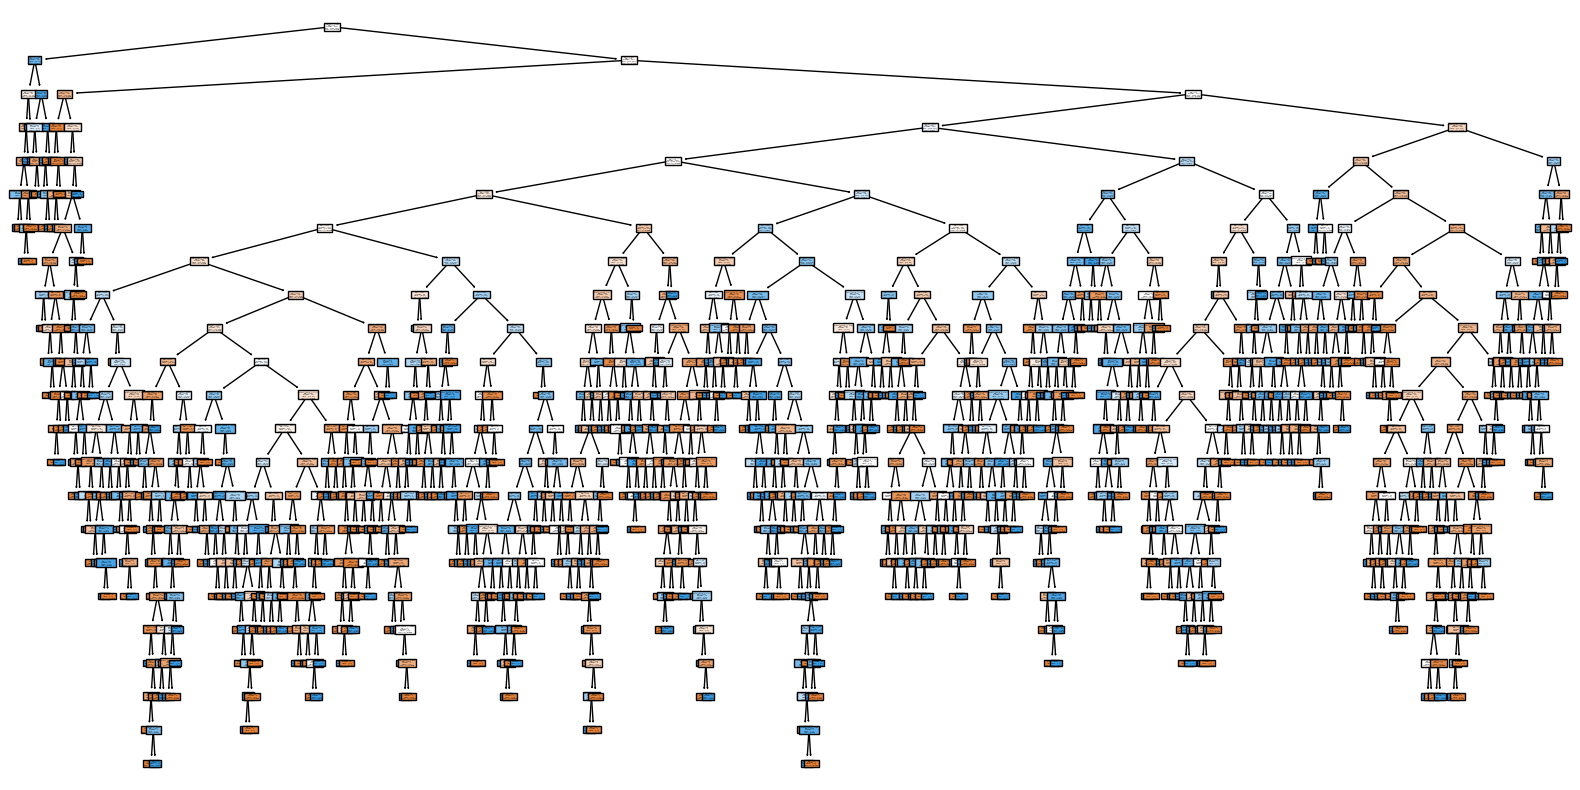

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=data.columns[:-1], class_names=['Non Potable', 'Potable'])
plt.show()

**Optimiser les hyperparamètres:**

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Meilleure accuracy : 0.6148651439299124


La meilleure accuracy obtenue après optimisation est de 61.49 %, ce qui est une légère amélioration par rapport à la performance initiale (60.71 % en validation croisée).

Cela montre que l'optimisation des hyperparamètres a permis d'améliorer légèrement la performance du modèle.

# Synthèse Globale


**Performance :**

Random Forest est le modèle le plus performant, avec une accuracy moyenne de 70.19 % en validation croisée.

SVM et Arbre de Décision montrent des performances modérées, tandis que KNN est le moins performant.

**Gestion du déséquilibre des classes :**

Tous les modèles ont été configurés avec class_weight='balanced' pour gérer le déséquilibre des classes.

Random Forest et SVM ont montré une meilleure capacité à gérer ce déséquilibre que KNN et l'Arbre de Décision.

**Sur-ajustement :**

Les modèles SVM, Arbre de Décision, et Random Forest ont montré une accuracy de 100 % sur l'ensemble complet, ce qui suggère un risque de sur-ajustement.

La validation croisée a permis d'identifier ce problème et de fournir une estimation plus réaliste de la performance.

**Interprétabilité :**

L'Arbre de Décision est le modèle le plus interprétable, mais il est moins performant que Random Forest.

Random Forest offre un bon équilibre entre performance et interprétabilité (via l'importance des caractéristiques).